# Part 3b: Base Models vs Fine-tuned Models Comparison

This notebook evaluates **pre-trained (non-fine-tuned)** models on the same test set used for the fine-tuned models, providing a fair comparison that quantifies the value of fine-tuning.

**Models evaluated:**
| Model | Approach |
|-------|----------|
| FinBERT (base) | Direct inference with pre-trained sentiment head |
| RoBERTa (zero-shot) | Zero-shot classification via NLI model |
| FinBERT (fine-tuned) | Fine-tuned on Financial PhraseBank |
| RoBERTa (fine-tuned) | Fine-tuned on Financial PhraseBank |

## 1. Setup & Data Loading

In [1]:
import sys
import json
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

# Add project root to path
sys.path.insert(0, str(Path.cwd().parent))

from config.paths import PROJECT_ROOT, FIGURES_DIR, SPLITS_DIR
from config.params import LABEL_LIST, BATCH_SIZE, MAX_SEQ_LENGTH
from src.data.dataset import FinancialSentimentDataset, load_splits
from src.models.classifier import SentimentClassifier, load_model
from src.models.evaluator import ModelEvaluator, evaluate_model_on_test
from src.visualization.training_viz import (
    plot_confusion_matrix,
    plot_per_class_metrics,
    plot_multi_model_comparison,
)

warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
print(f"Project root: {PROJECT_ROOT}")

Device: cuda
Project root: C:\Users\seliv\OneDrive\Desktop\Financial Sentiment Analysis


In [2]:
# Load test split
test_df = pd.read_csv(SPLITS_DIR / 'test.csv')
print(f"Test set: {len(test_df)} samples")
print(f"\nLabel distribution:")
print(test_df['label'].value_counts().sort_index())

Test set: 518 samples

Label distribution:
label
0     63
1    322
2    133
Name: count, dtype: int64


In [3]:
# Prepare test DataLoader for FinBERT base evaluation
from torch.utils.data import DataLoader

TEXT_COL = 'sentence'  # column name in test.csv

test_texts = test_df[TEXT_COL].tolist()
test_labels = test_df['label'].tolist()

finbert_test_dataset = FinancialSentimentDataset(
    texts=test_texts,
    labels=test_labels,
    tokenizer_name='ProsusAI/finbert',
    max_length=MAX_SEQ_LENGTH
)

finbert_test_loader = DataLoader(
    finbert_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"Test DataLoader: {len(finbert_test_loader)} batches")

Test DataLoader: 33 batches


## 2. FinBERT Base (Pre-trained) Evaluation

FinBERT (`ProsusAI/finbert`) ships with a 3-class sentiment head trained on financial data. We evaluate it directly without any fine-tuning on our dataset.

**Label remapping**: FinBERT uses `0=positive, 1=negative, 2=neutral`, while our project uses `0=negative, 1=neutral, 2=positive`.

In [4]:
# Load pre-trained FinBERT (no fine-tuning)
finbert_base = SentimentClassifier('ProsusAI/finbert', num_labels=3)
finbert_base.to(device)
finbert_base.eval()

print(f"FinBERT base parameters: {finbert_base.get_total_parameters():,}")

FinBERT base parameters: 109,484,547


In [5]:
# Run inference on test set
raw_preds, raw_labels, raw_probs = evaluate_model_on_test(
    finbert_base, finbert_test_loader, device=device
)

# Remap FinBERT labels: FinBERT 0=positive -> ours 2, FinBERT 1=negative -> ours 0, FinBERT 2=neutral -> ours 1
FINBERT_TO_PROJECT = {0: 2, 1: 0, 2: 1}  # positive->2, negative->0, neutral->1

finbert_base_preds = np.array([FINBERT_TO_PROJECT[p] for p in raw_preds])

# Also remap probabilities: reorder columns from [pos, neg, neu] to [neg, neu, pos]
finbert_base_probs = np.zeros_like(raw_probs)
finbert_base_probs[:, 0] = raw_probs[:, 1]  # negative
finbert_base_probs[:, 1] = raw_probs[:, 2]  # neutral
finbert_base_probs[:, 2] = raw_probs[:, 0]  # positive

finbert_base_labels = raw_labels  # labels are already in project format

print(f"Predictions shape: {finbert_base_preds.shape}")
print(f"Unique predictions: {np.unique(finbert_base_preds, return_counts=True)}")

Evaluating on test set: 100%|██████████| 33/33 [00:05<00:00,  6.36it/s]

Predictions shape: (518,)
Unique predictions: (array([0, 1, 2]), array([ 70, 304, 144]))


In [6]:
# Compute metrics
evaluator = ModelEvaluator(label_names=LABEL_LIST)

finbert_base_metrics = evaluator.compute_metrics(finbert_base_preds, finbert_base_labels)

print("=" * 60)
print("FinBERT Base (Pre-trained) - Test Set Results")
print("=" * 60)
print(f"Accuracy:         {finbert_base_metrics['accuracy']:.4f}")
print(f"F1 (weighted):    {finbert_base_metrics['f1_weighted']:.4f}")
print(f"F1 (macro):       {finbert_base_metrics['f1_macro']:.4f}")
print(f"Precision (wtd):  {finbert_base_metrics['precision_weighted']:.4f}")
print(f"Recall (wtd):     {finbert_base_metrics['recall_weighted']:.4f}")
print("\nClassification Report:")
print(evaluator.get_classification_report(finbert_base_preds, finbert_base_labels))

FinBERT Base (Pre-trained) - Test Set Results
Accuracy:         0.9479
F1 (weighted):    0.9486
F1 (macro):       0.9354
Precision (wtd):  0.9517
Recall (wtd):     0.9479

Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.97      0.92        63
     neutral       0.99      0.94      0.96       322
    positive       0.89      0.96      0.92       133

    accuracy                           0.95       518
   macro avg       0.92      0.96      0.94       518
weighted avg       0.95      0.95      0.95       518



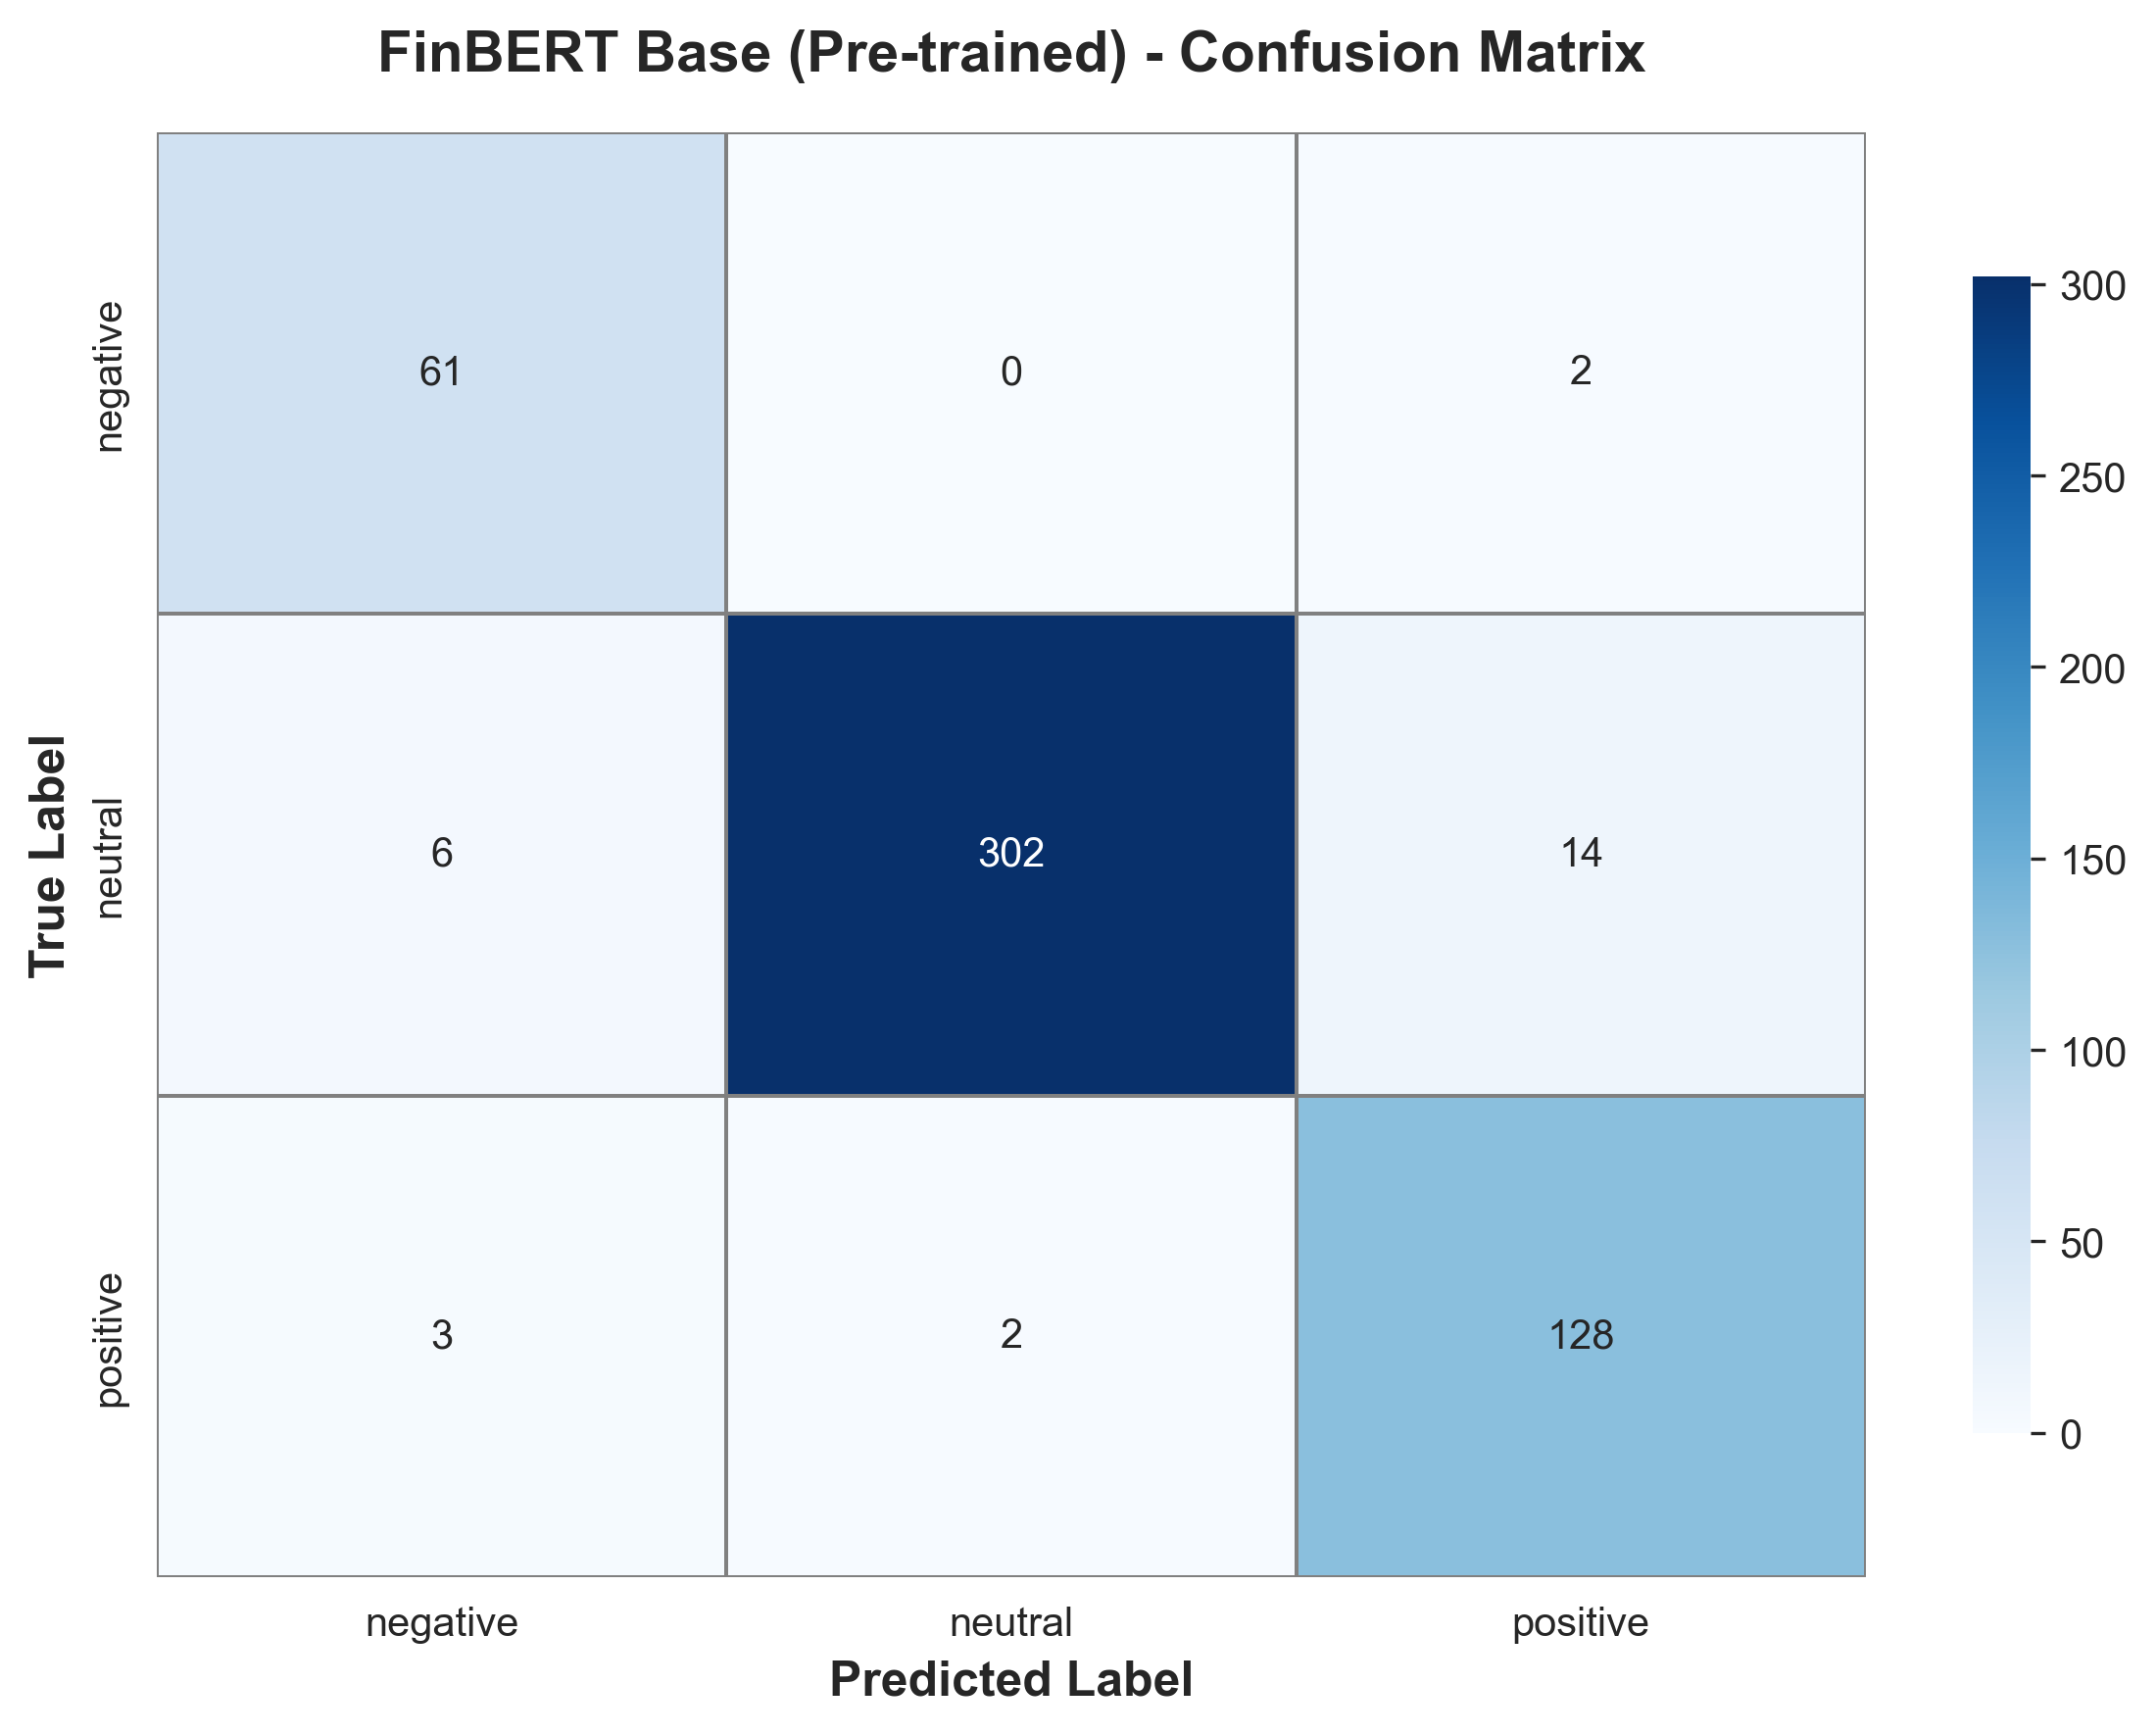

(<Figure size 2400x1800 with 2 Axes>,
 <Axes: title={'center': 'FinBERT Base (Pre-trained) - Confusion Matrix'}, xlabel='Predicted Label', ylabel='True Label'>)

In [7]:
# Confusion matrix
cm_finbert_base = evaluator.get_confusion_matrix(finbert_base_preds, finbert_base_labels)
plot_confusion_matrix(
    cm_finbert_base, LABEL_LIST,
    save_path=str(FIGURES_DIR / 'finbert_base_confusion_matrix.png'),
    title='FinBERT Base (Pre-trained) - Confusion Matrix'
)

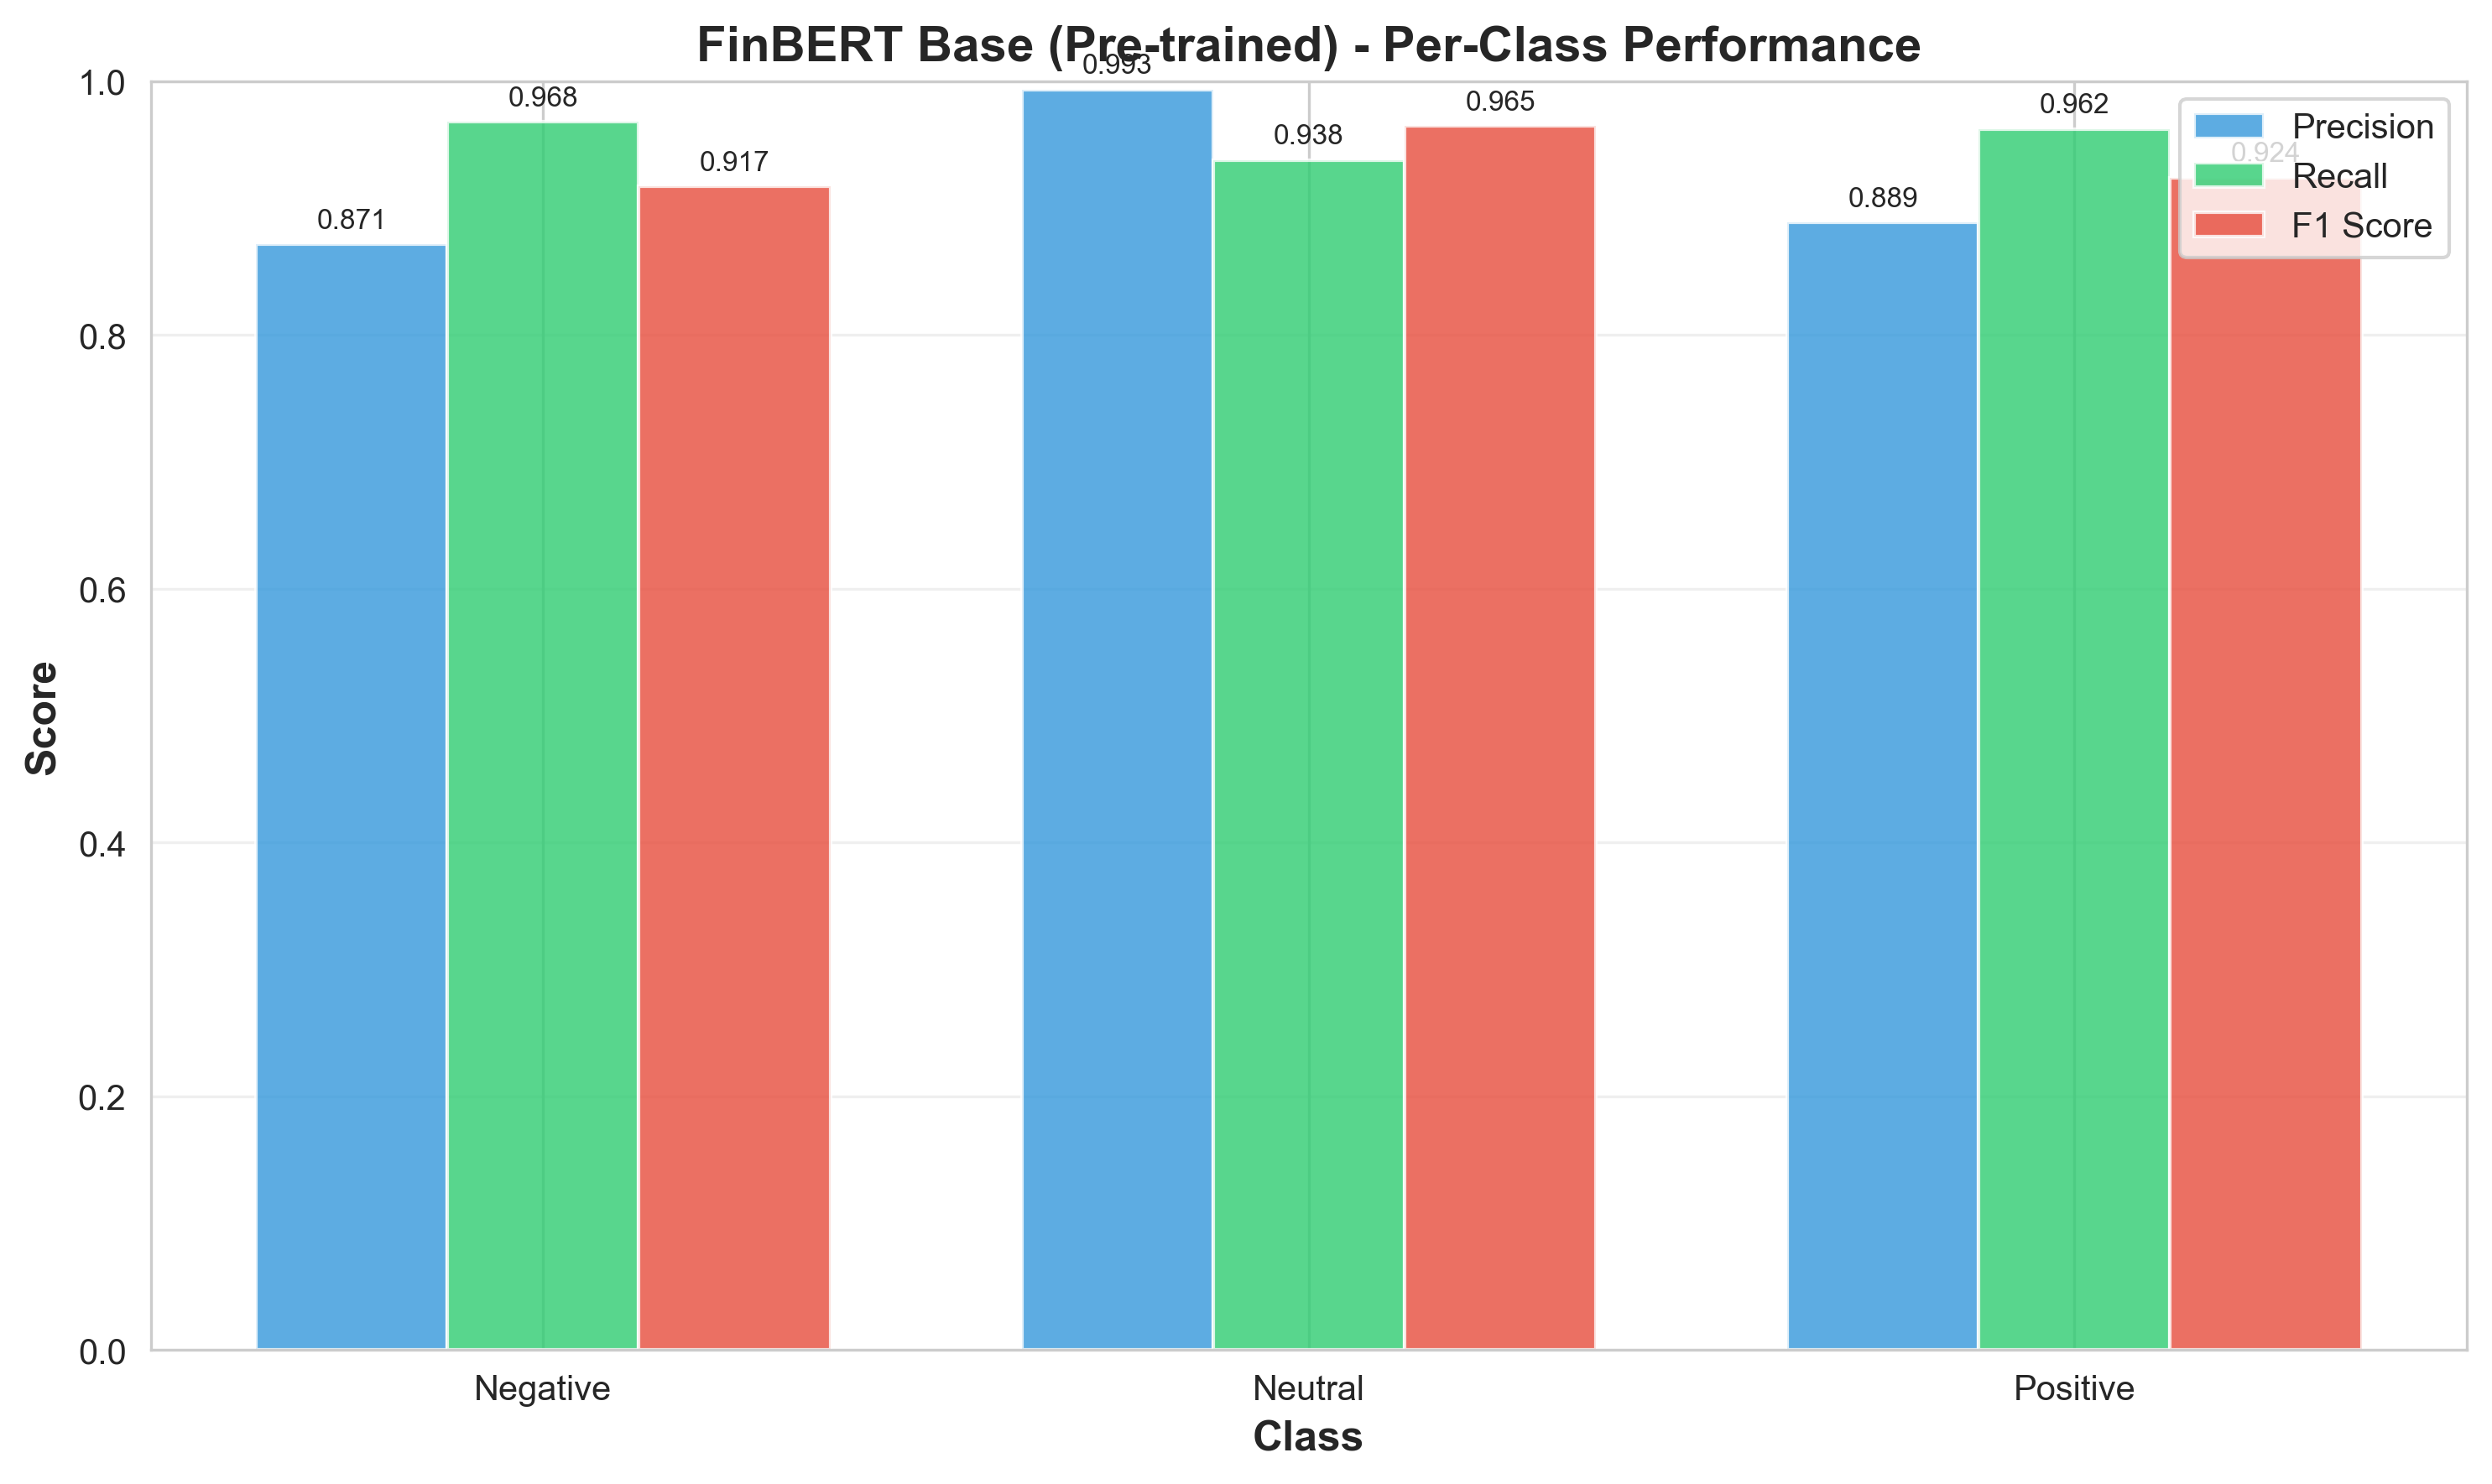

(<Figure size 3000x1800 with 1 Axes>,
 <Axes: title={'center': 'FinBERT Base (Pre-trained) - Per-Class Performance'}, xlabel='Class', ylabel='Score'>)

In [8]:
# Per-class metrics
plot_per_class_metrics(
    finbert_base_metrics, LABEL_LIST,
    save_path=str(FIGURES_DIR / 'finbert_base_per_class.png'),
    title='FinBERT Base (Pre-trained) - Per-Class Performance'
)

In [9]:
# Free GPU memory
del finbert_base
torch.cuda.empty_cache() if torch.cuda.is_available() else None

## 3. RoBERTa Zero-shot Evaluation

We use the HuggingFace `zero-shot-classification` pipeline with an NLI-based model (`facebook/bart-large-mnli`) to classify financial texts without any task-specific training.

In [10]:
from transformers import pipeline

# Load zero-shot classification pipeline
zs_classifier = pipeline(
    'zero-shot-classification',
    model='facebook/bart-large-mnli',
    device=0 if torch.cuda.is_available() else -1
)

candidate_labels = ['negative', 'neutral', 'positive']
print(f"Zero-shot classifier loaded on device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


Zero-shot classifier loaded on device: cuda


In [11]:
# Run zero-shot inference on test texts
zs_predictions = []
zs_probabilities = []

label_to_idx = {'negative': 0, 'neutral': 1, 'positive': 2}

for text in tqdm(test_texts, desc="Zero-shot inference"):
    result = zs_classifier(text, candidate_labels)
    
    # Map pipeline output to ordered probabilities [neg, neu, pos]
    probs = [0.0, 0.0, 0.0]
    for label, score in zip(result['labels'], result['scores']):
        probs[label_to_idx[label]] = score
    
    pred_label = result['labels'][0]  # highest scoring label
    pred_idx = label_to_idx[pred_label]
    
    zs_predictions.append(pred_idx)
    zs_probabilities.append(probs)

zs_preds = np.array(zs_predictions)
zs_probs = np.array(zs_probabilities)
zs_labels = np.array(test_labels)

print(f"\nPredictions shape: {zs_preds.shape}")
print(f"Unique predictions: {np.unique(zs_preds, return_counts=True)}")

Zero-shot inference: 100%|██████████| 518/518 [00:43<00:00, 11.95it/s]


Predictions shape: (518,)
Unique predictions: (array([0, 1, 2]), array([134,  18, 366]))


In [12]:
# Compute metrics
zs_metrics = evaluator.compute_metrics(zs_preds, zs_labels)

print("=" * 60)
print("RoBERTa Zero-shot (BART-MNLI) - Test Set Results")
print("=" * 60)
print(f"Accuracy:         {zs_metrics['accuracy']:.4f}")
print(f"F1 (weighted):    {zs_metrics['f1_weighted']:.4f}")
print(f"F1 (macro):       {zs_metrics['f1_macro']:.4f}")
print(f"Precision (wtd):  {zs_metrics['precision_weighted']:.4f}")
print(f"Recall (wtd):     {zs_metrics['recall_weighted']:.4f}")
print("\nClassification Report:")
print(evaluator.get_classification_report(zs_preds, zs_labels))

RoBERTa Zero-shot (BART-MNLI) - Test Set Results
Accuracy:         0.3996
F1 (weighted):    0.2731
F1 (macro):       0.4148
Precision (wtd):  0.7670
Recall (wtd):     0.3996

Classification Report:
              precision    recall  f1-score   support

    negative       0.46      0.98      0.63        63
     neutral       1.00      0.06      0.11       322
    positive       0.35      0.95      0.51       133

    accuracy                           0.40       518
   macro avg       0.60      0.66      0.41       518
weighted avg       0.77      0.40      0.27       518



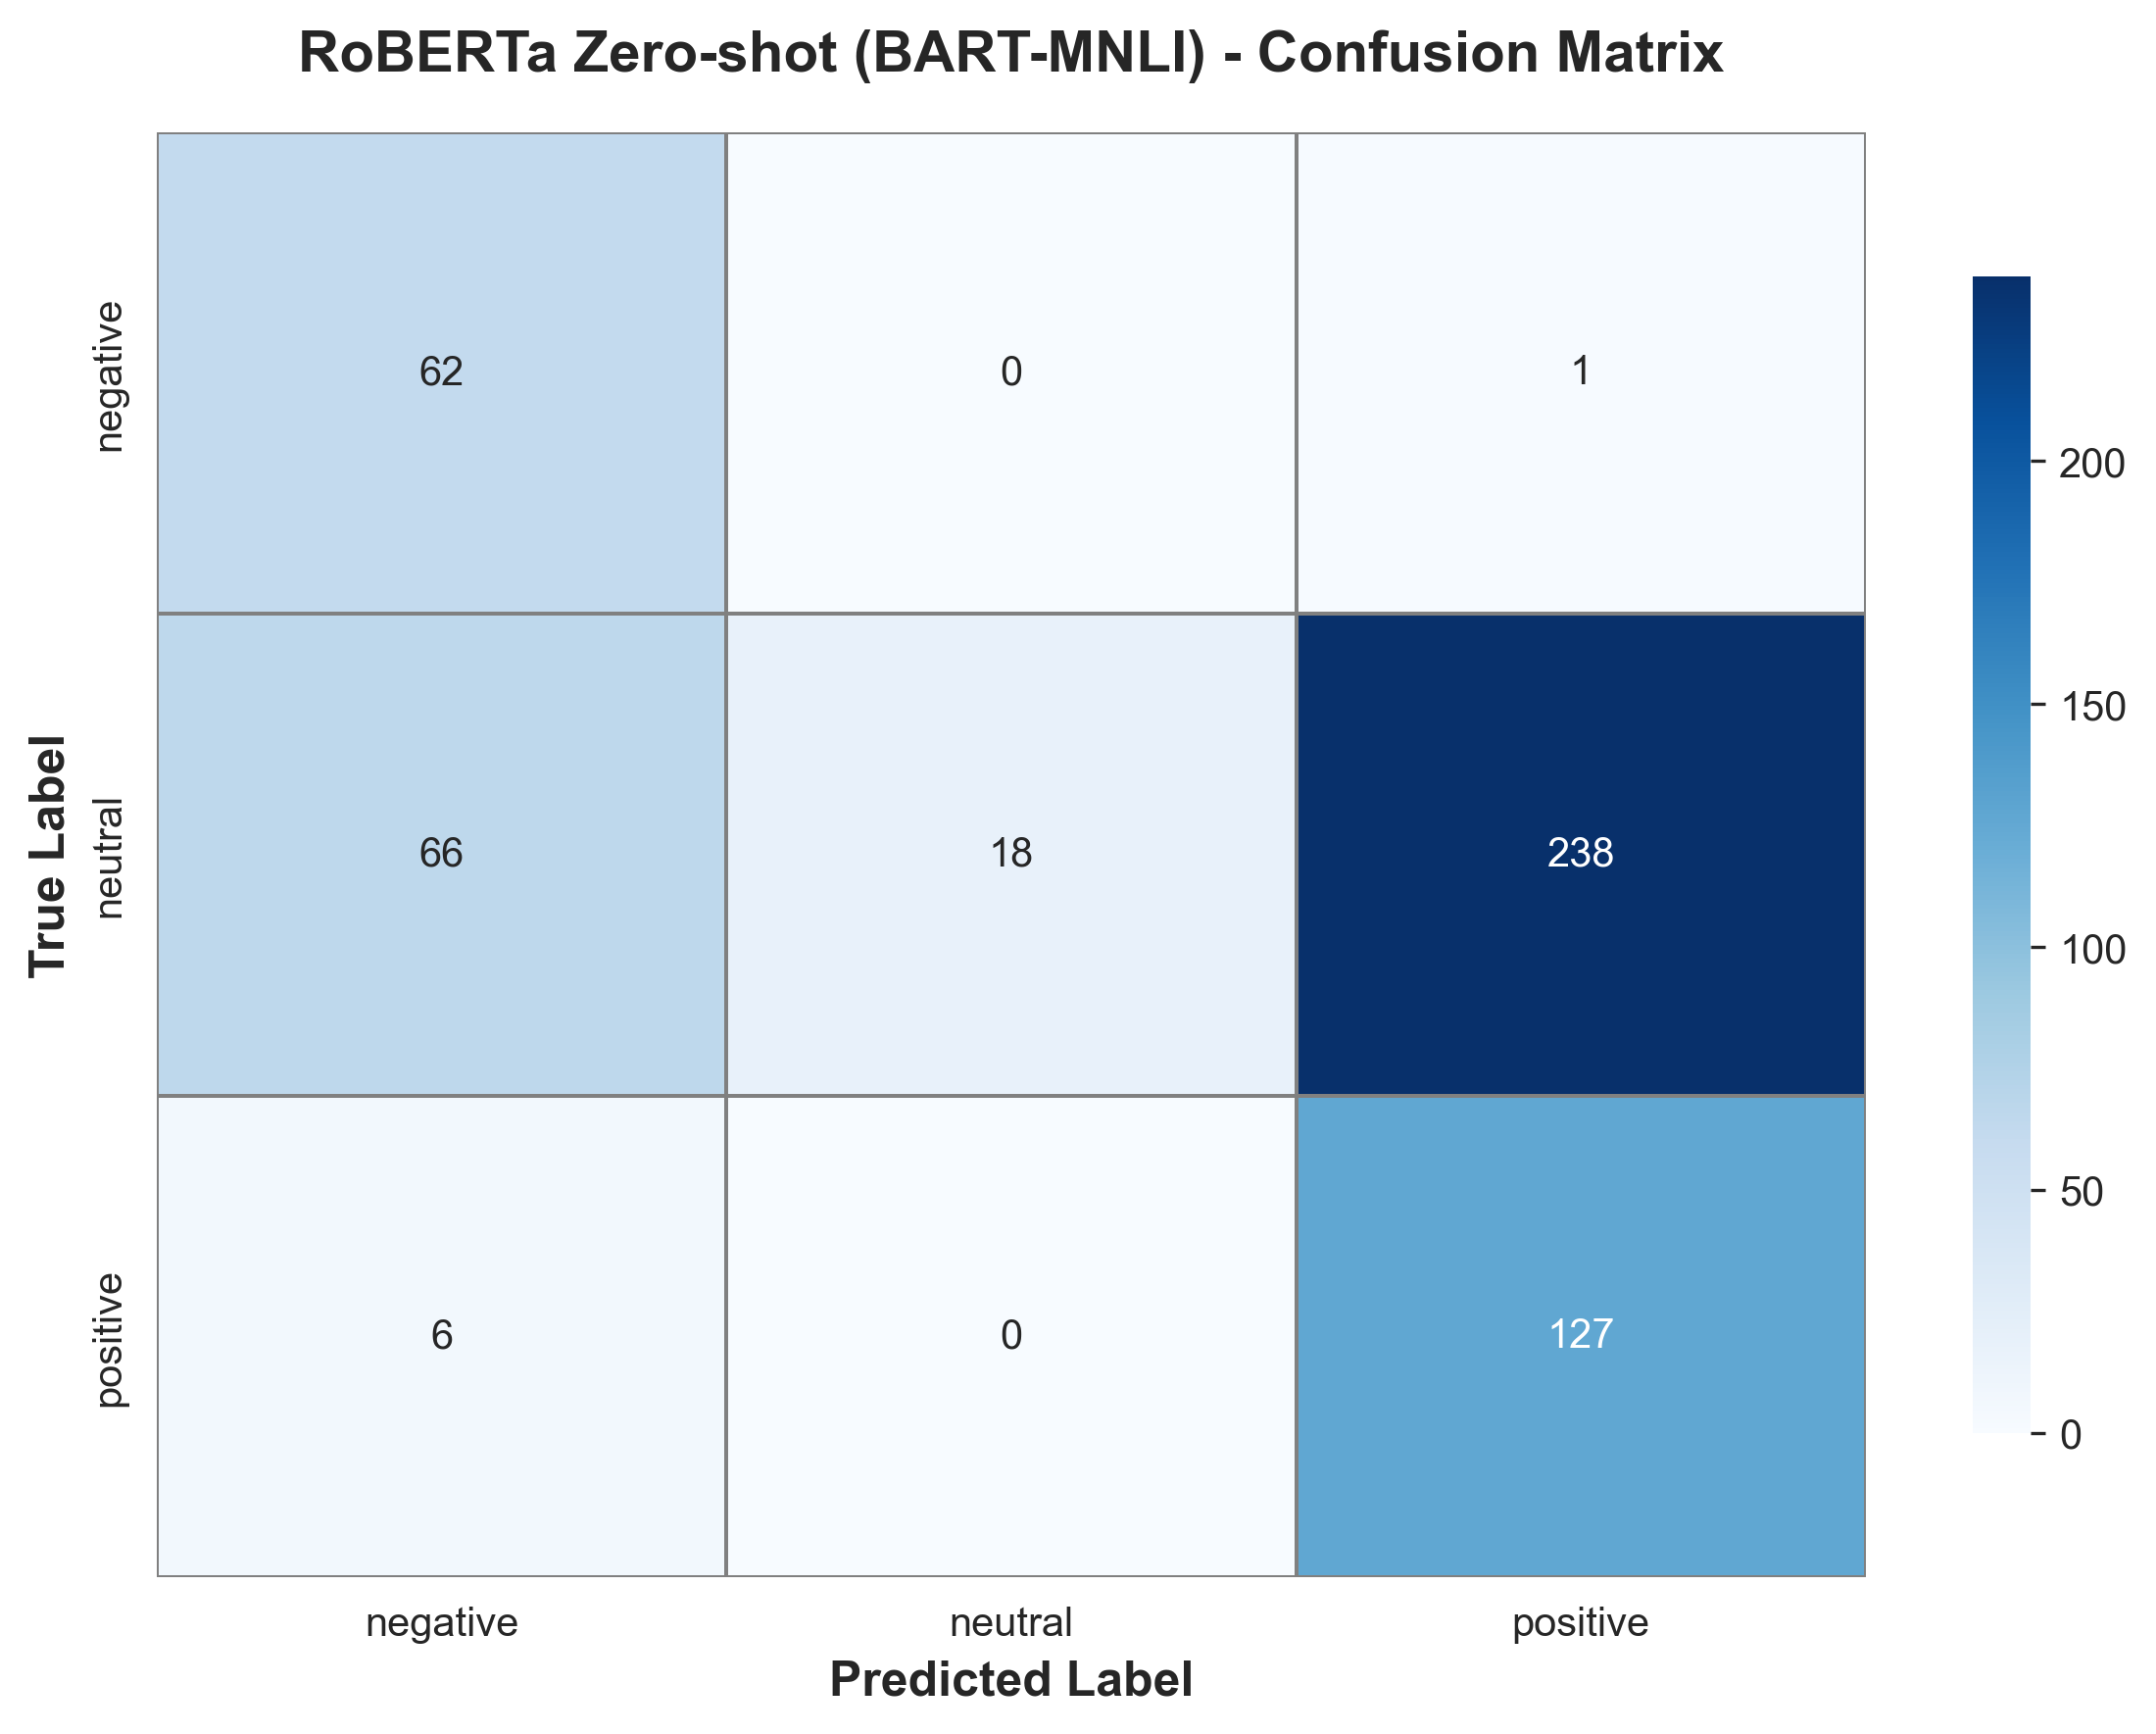

(<Figure size 2400x1800 with 2 Axes>,
 <Axes: title={'center': 'RoBERTa Zero-shot (BART-MNLI) - Confusion Matrix'}, xlabel='Predicted Label', ylabel='True Label'>)

In [13]:
# Confusion matrix
cm_zs = evaluator.get_confusion_matrix(zs_preds, zs_labels)
plot_confusion_matrix(
    cm_zs, LABEL_LIST,
    save_path=str(FIGURES_DIR / 'roberta_zs_confusion_matrix.png'),
    title='RoBERTa Zero-shot (BART-MNLI) - Confusion Matrix'
)

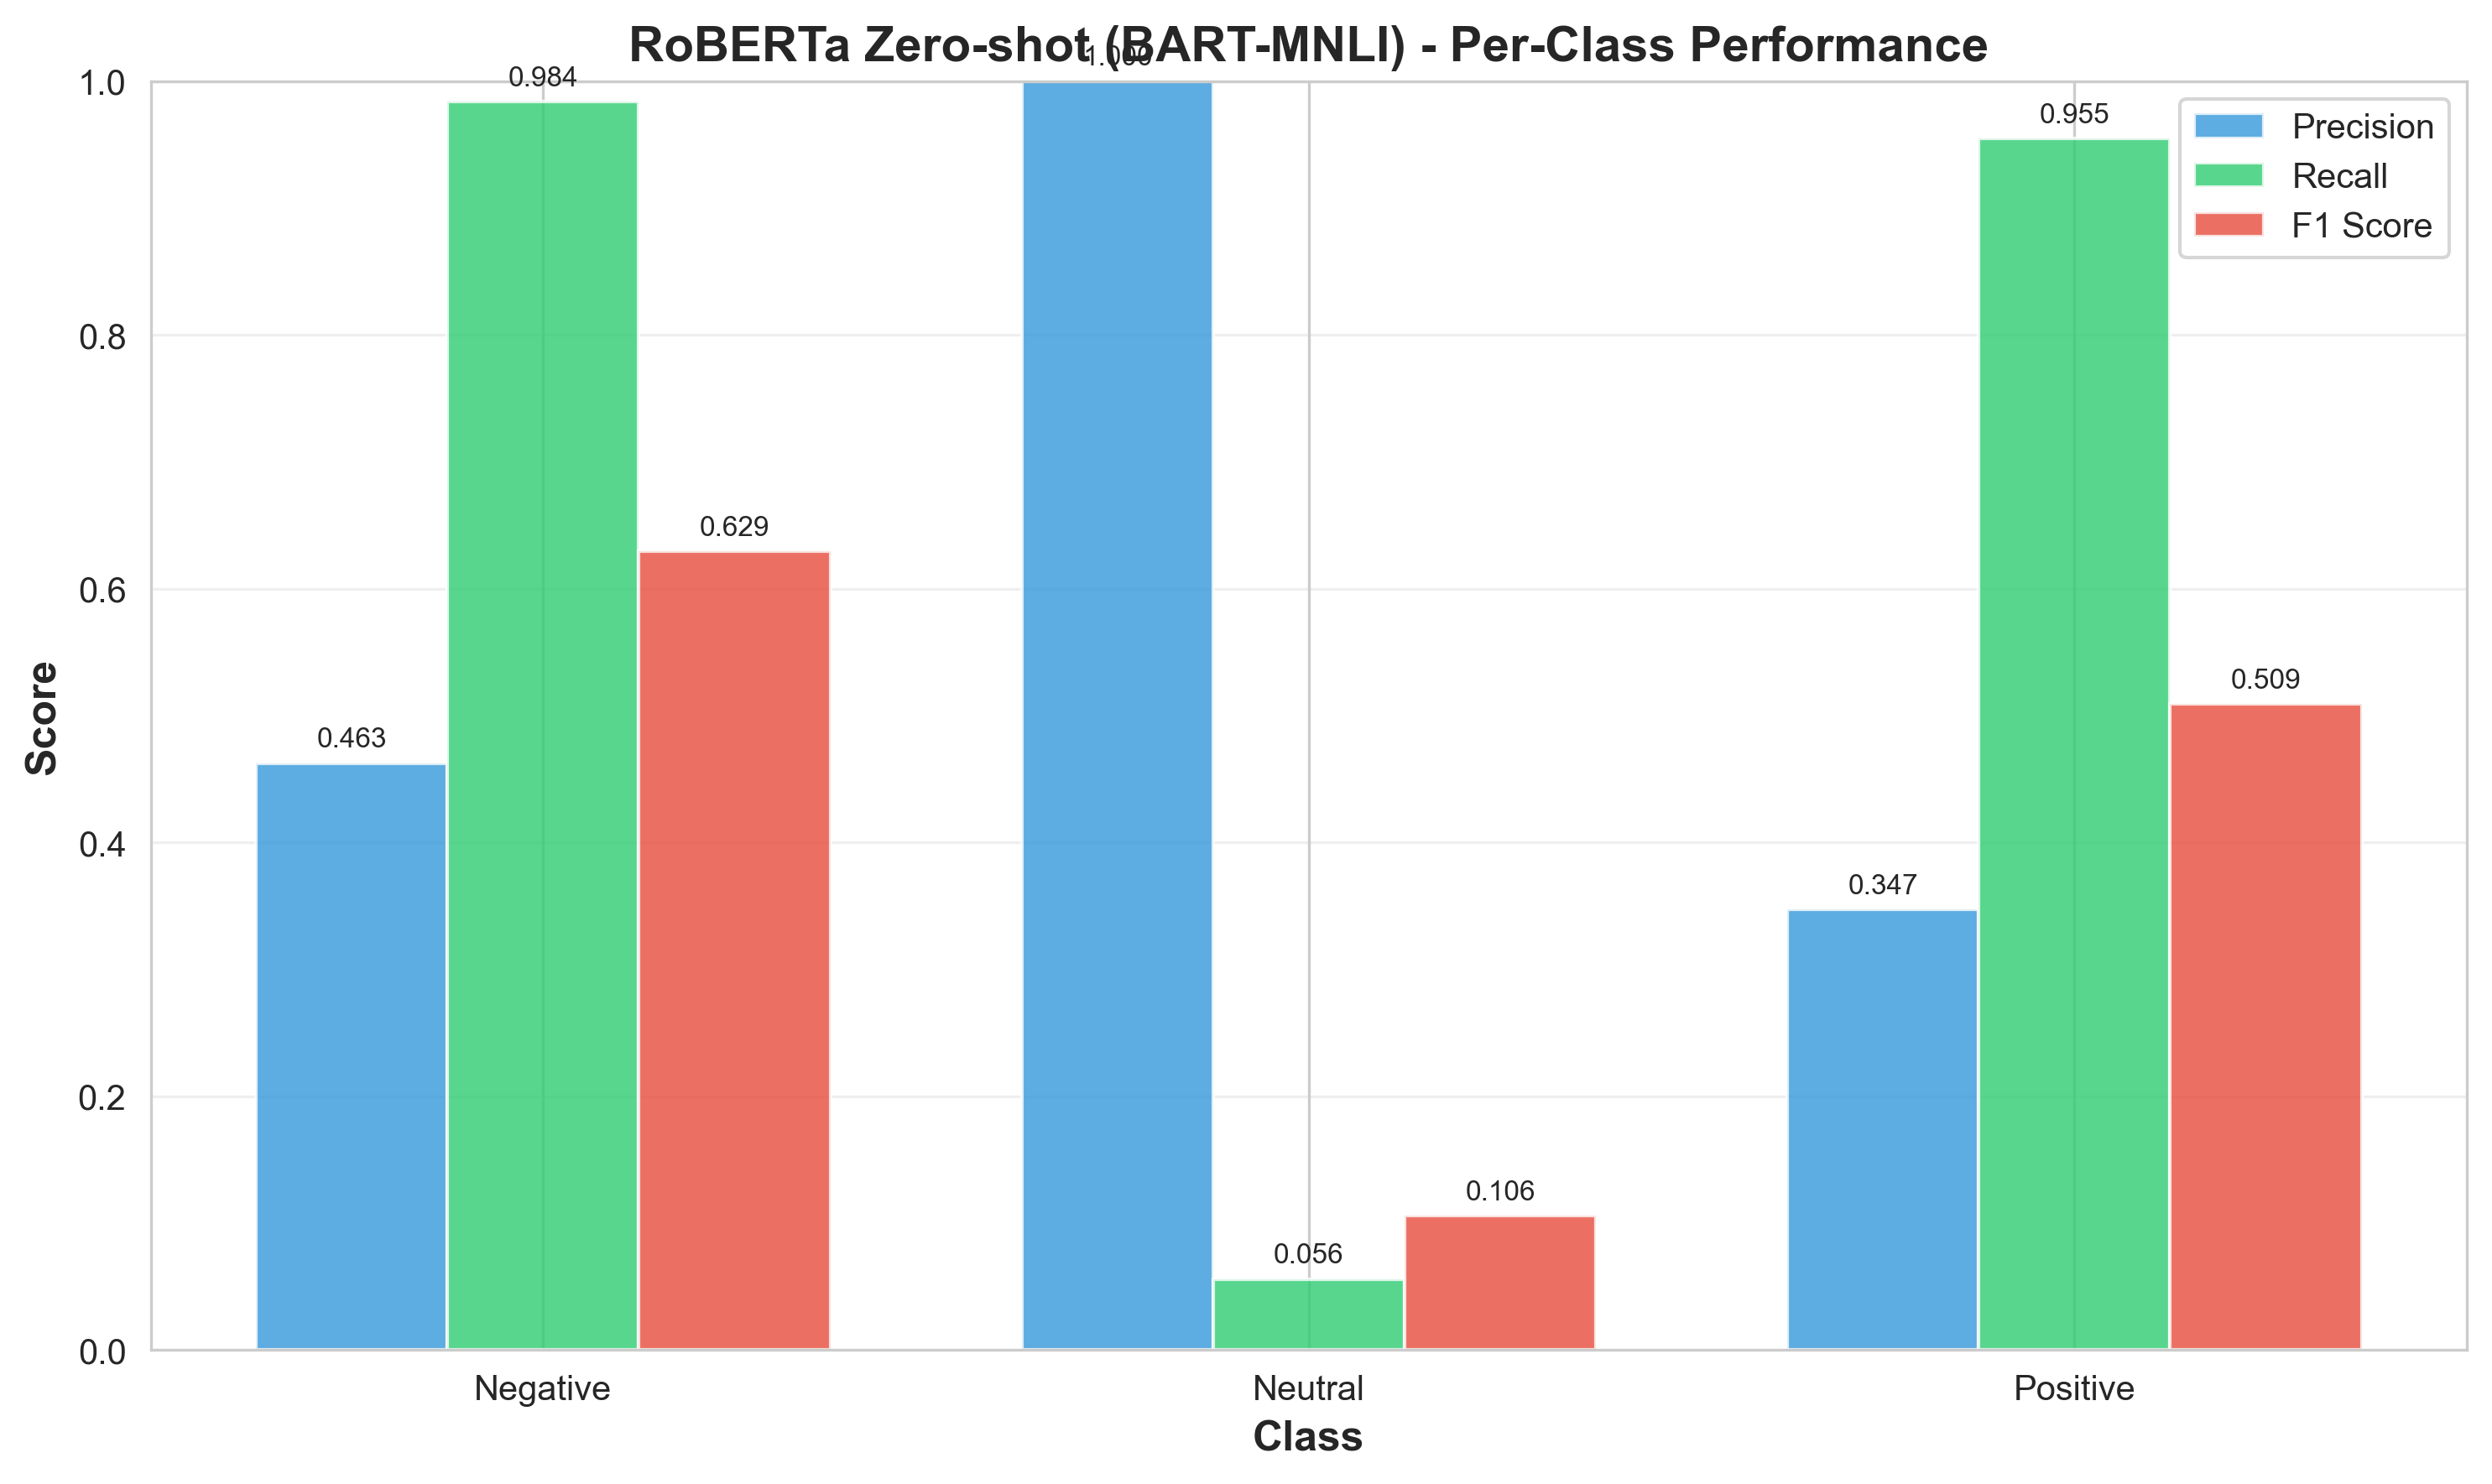

(<Figure size 3000x1800 with 1 Axes>,
 <Axes: title={'center': 'RoBERTa Zero-shot (BART-MNLI) - Per-Class Performance'}, xlabel='Class', ylabel='Score'>)

In [14]:
# Per-class metrics
plot_per_class_metrics(
    zs_metrics, LABEL_LIST,
    save_path=str(FIGURES_DIR / 'roberta_zs_per_class.png'),
    title='RoBERTa Zero-shot (BART-MNLI) - Per-Class Performance'
)

In [15]:
# Free GPU memory
del zs_classifier
torch.cuda.empty_cache() if torch.cuda.is_available() else None

## 4. Load Fine-tuned Results

Load the fine-tuned model metrics from `experiments/results.json` for comparison.

In [16]:
# Load fine-tuned results
results_path = PROJECT_ROOT / 'experiments' / 'results.json'
with open(results_path, 'r') as f:
    results_data = json.load(f)

# Extract fine-tuned metrics into standard format
finetuned_metrics = {}

for exp in results_data['experiments']:
    r = exp['results']
    name = 'FinBERT (fine-tuned)' if exp['model'] == 'finbert' else 'RoBERTa (fine-tuned)'
    finetuned_metrics[name] = {
        'accuracy': r['test_accuracy'],
        'precision_weighted': r['test_precision'],
        'recall_weighted': r['test_recall'],
        'f1_weighted': r['test_f1_weighted'],
        'f1_macro': r['test_f1_macro'],
        'f1_per_class': r['per_class_f1'],
    }

for name, m in finetuned_metrics.items():
    print(f"\n{name}:")
    print(f"  Accuracy: {m['accuracy']:.4f}  |  F1 (weighted): {m['f1_weighted']:.4f}  |  F1 (macro): {m['f1_macro']:.4f}")


RoBERTa (fine-tuned):
  Accuracy: 0.9112  |  F1 (weighted): 0.9138  |  F1 (macro): 0.9093

FinBERT (fine-tuned):
  Accuracy: 0.9556  |  F1 (weighted): 0.9563  |  F1 (macro): 0.9502


## 5. Comprehensive Comparison

Compare all four models: FinBERT base, RoBERTa zero-shot, FinBERT fine-tuned, and RoBERTa fine-tuned.

In [17]:
# Build comparison dictionary
all_metrics = {
    'FinBERT (base)': finbert_base_metrics,
    'RoBERTa (zero-shot)': zs_metrics,
    'FinBERT (fine-tuned)': finetuned_metrics['FinBERT (fine-tuned)'],
    'RoBERTa (fine-tuned)': finetuned_metrics['RoBERTa (fine-tuned)'],
}

# Create comparison table
comparison_rows = []
metric_keys = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'f1_macro']
metric_labels = ['Accuracy', 'Precision (wtd)', 'Recall (wtd)', 'F1 (weighted)', 'F1 (macro)']

for key, label in zip(metric_keys, metric_labels):
    row = {'Metric': label}
    for model_name, m in all_metrics.items():
        row[model_name] = f"{m.get(key, 0.0):.4f}"
    comparison_rows.append(row)

comparison_df = pd.DataFrame(comparison_rows)
print("=" * 90)
print("4-Model Comparison on Test Set")
print("=" * 90)
print(comparison_df.to_string(index=False))

4-Model Comparison on Test Set
         Metric FinBERT (base) RoBERTa (zero-shot) FinBERT (fine-tuned) RoBERTa (fine-tuned)
       Accuracy         0.9479              0.3996               0.9556               0.9112
Precision (wtd)         0.9517              0.7670               0.9602               0.9280
   Recall (wtd)         0.9479              0.3996               0.9556               0.9112
  F1 (weighted)         0.9486              0.2731               0.9563               0.9138
     F1 (macro)         0.9354              0.4148               0.9502               0.9093


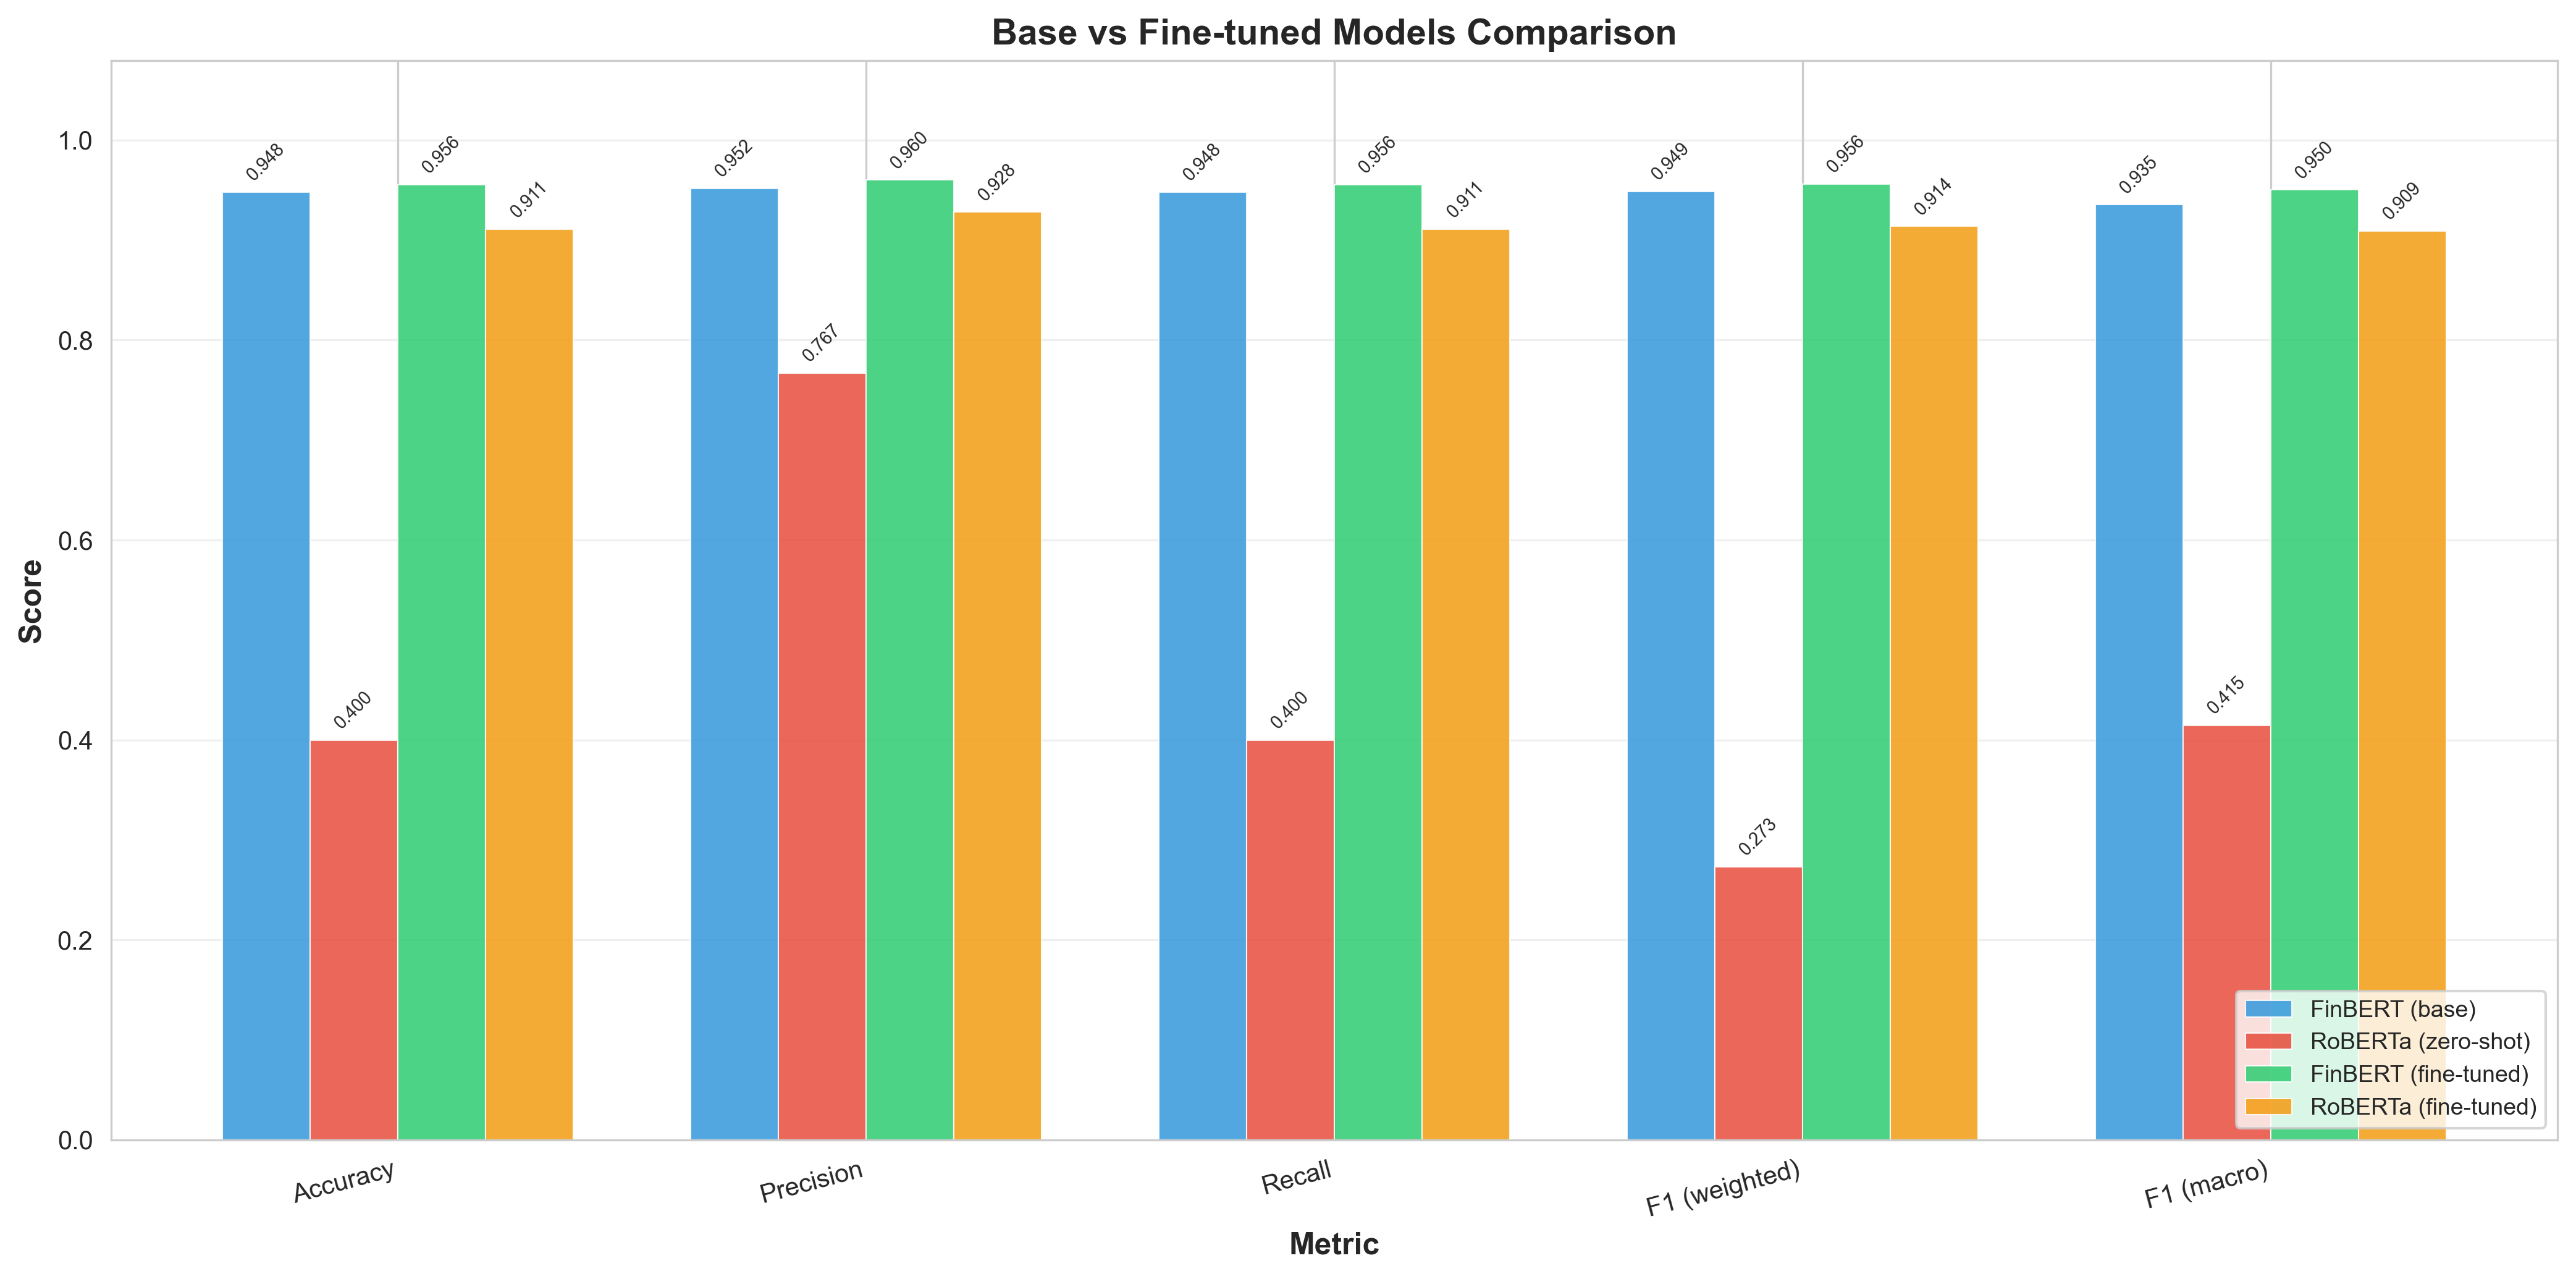

(<Figure size 4200x2100 with 1 Axes>,
 <Axes: title={'center': 'Base vs Fine-tuned Models Comparison'}, xlabel='Metric', ylabel='Score'>)

In [18]:
# Multi-model bar chart
plot_multi_model_comparison(
    all_metrics,
    save_path=str(FIGURES_DIR / 'multi_model_comparison.png'),
    title='Base vs Fine-tuned Models Comparison'
)

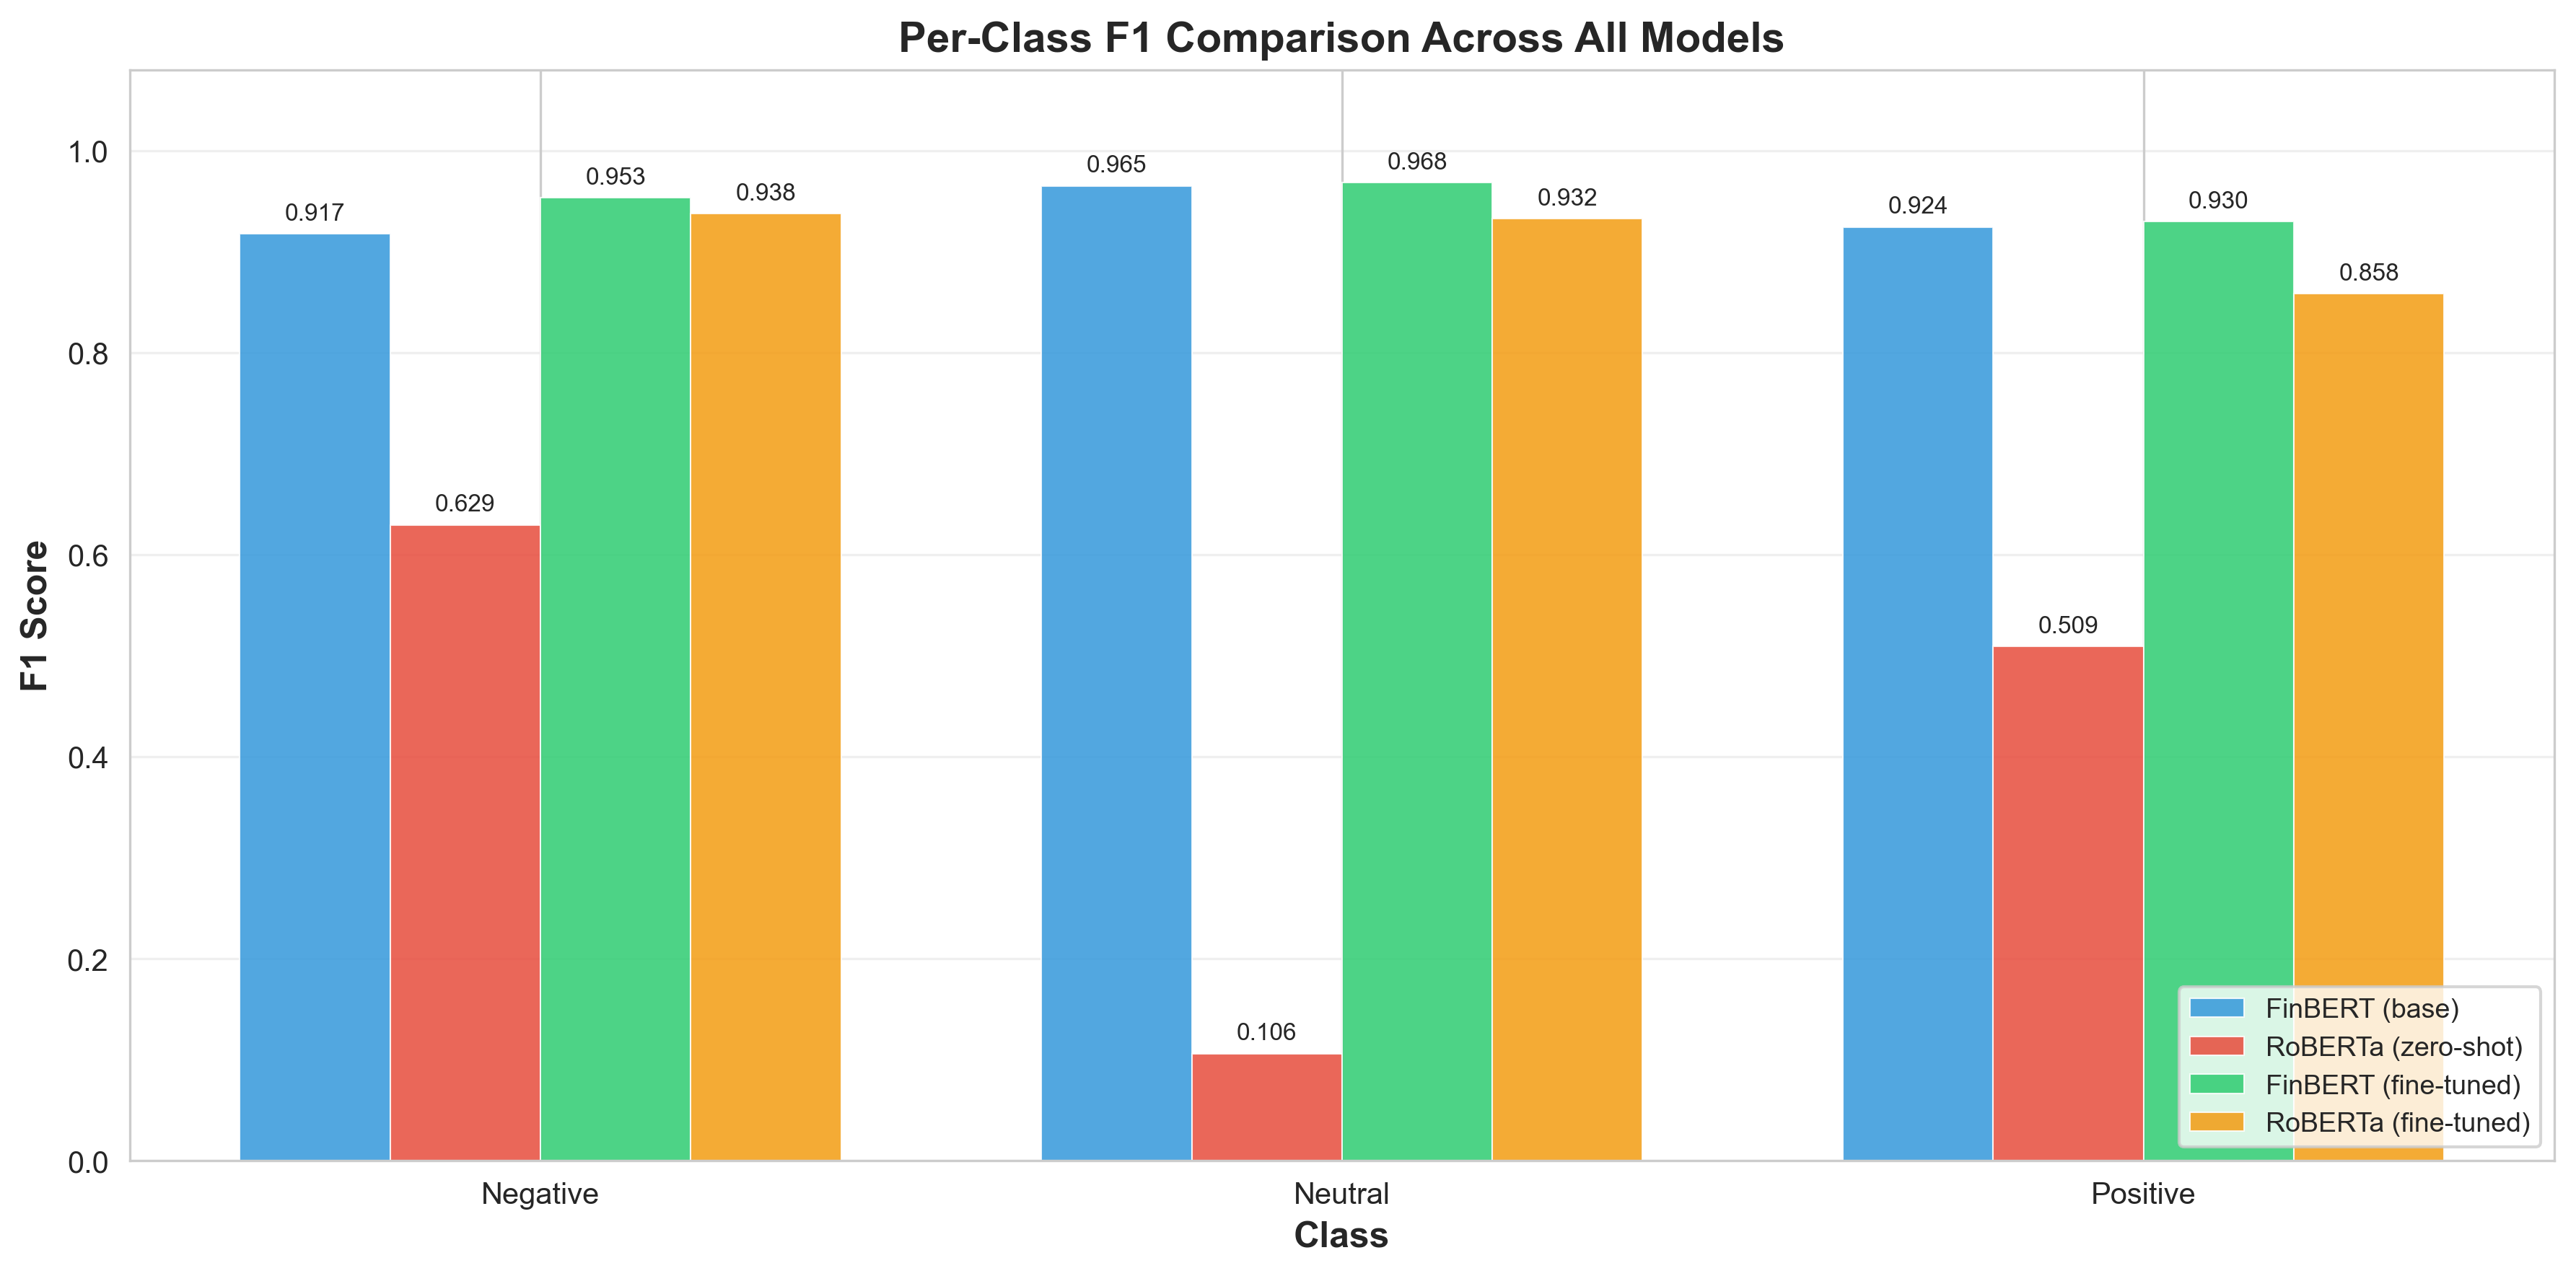

In [19]:
# Per-class F1 comparison across all 4 models
import matplotlib.pyplot as plt

f1_data = {}
for model_name, m in all_metrics.items():
    f1_data[model_name] = m.get('f1_per_class', [0.0, 0.0, 0.0])

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(LABEL_LIST))
n_models = len(f1_data)
total_width = 0.75
bar_width = total_width / n_models
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for i, (model_name, f1_values) in enumerate(f1_data.items()):
    offset = (i - n_models / 2 + 0.5) * bar_width
    bars = ax.bar(x + offset, f1_values, bar_width, label=model_name,
                  alpha=0.85, color=colors[i], edgecolor='white', linewidth=0.5)
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class F1 Comparison Across All Models', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([l.capitalize() for l in LABEL_LIST])
ax.set_ylim([0, 1.08])
ax.legend(loc='lower right', fontsize=9)
ax.yaxis.grid(True, alpha=0.3)
ax.set_axisbelow(True)
plt.tight_layout()
fig.savefig(str(FIGURES_DIR / 'per_class_f1_all_models.png'), dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# Fine-tuning improvement summary
print("=" * 70)
print("Fine-tuning Improvement Summary")
print("=" * 70)

pairs = [
    ('FinBERT (base)', 'FinBERT (fine-tuned)'),
    ('RoBERTa (zero-shot)', 'RoBERTa (fine-tuned)'),
]

for base_name, ft_name in pairs:
    base_m = all_metrics[base_name]
    ft_m = all_metrics[ft_name]
    
    print(f"\n{base_name} -> {ft_name}:")
    for key, label in zip(metric_keys, metric_labels):
        base_val = base_m.get(key, 0.0)
        ft_val = ft_m.get(key, 0.0)
        abs_diff = ft_val - base_val
        rel_diff = (abs_diff / base_val * 100) if base_val > 0 else float('inf')
        print(f"  {label:20s}: {base_val:.4f} -> {ft_val:.4f}  ({abs_diff:+.4f}, {rel_diff:+.1f}%)")

Fine-tuning Improvement Summary

FinBERT (base) -> FinBERT (fine-tuned):
  Accuracy            : 0.9479 -> 0.9556  (+0.0077, +0.8%)
  Precision (wtd)     : 0.9517 -> 0.9602  (+0.0085, +0.9%)
  Recall (wtd)        : 0.9479 -> 0.9556  (+0.0077, +0.8%)
  F1 (weighted)       : 0.9486 -> 0.9563  (+0.0077, +0.8%)
  F1 (macro)          : 0.9354 -> 0.9502  (+0.0148, +1.6%)

RoBERTa (zero-shot) -> RoBERTa (fine-tuned):
  Accuracy            : 0.3996 -> 0.9112  (+0.5116, +128.0%)
  Precision (wtd)     : 0.7670 -> 0.9280  (+0.1610, +21.0%)
  Recall (wtd)        : 0.3996 -> 0.9112  (+0.5116, +128.0%)
  F1 (weighted)       : 0.2731 -> 0.9138  (+0.6408, +234.7%)
  F1 (macro)          : 0.4148 -> 0.9093  (+0.4945, +119.2%)


## 6. Update Results JSON

Add base model experiment results to `experiments/results.json`.

In [21]:
from datetime import datetime

# Add FinBERT base experiment
finbert_base_experiment = {
    'experiment_id': 3,
    'model': 'finbert-base',
    'timestamp': datetime.now().isoformat(),
    'config': {
        'approach': 'pretrained-direct',
        'model_checkpoint': 'ProsusAI/finbert',
        'fine_tuned': False,
        'label_remapping': 'FinBERT(0=pos,1=neg,2=neu) -> Project(0=neg,1=neu,2=pos)'
    },
    'results': {
        'test_accuracy': finbert_base_metrics['accuracy'],
        'test_precision': finbert_base_metrics['precision_weighted'],
        'test_recall': finbert_base_metrics['recall_weighted'],
        'test_f1_weighted': finbert_base_metrics['f1_weighted'],
        'test_f1_macro': finbert_base_metrics['f1_macro'],
        'per_class_f1': finbert_base_metrics['f1_per_class'],
    }
}

# Add RoBERTa zero-shot experiment
roberta_zs_experiment = {
    'experiment_id': 4,
    'model': 'roberta-zero-shot',
    'timestamp': datetime.now().isoformat(),
    'config': {
        'approach': 'zero-shot-classification',
        'model_checkpoint': 'facebook/bart-large-mnli',
        'fine_tuned': False,
        'candidate_labels': ['negative', 'neutral', 'positive']
    },
    'results': {
        'test_accuracy': zs_metrics['accuracy'],
        'test_precision': zs_metrics['precision_weighted'],
        'test_recall': zs_metrics['recall_weighted'],
        'test_f1_weighted': zs_metrics['f1_weighted'],
        'test_f1_macro': zs_metrics['f1_macro'],
        'per_class_f1': zs_metrics['f1_per_class'],
    }
}

# Update results data
# Remove old base experiments if re-running
results_data['experiments'] = [
    exp for exp in results_data['experiments']
    if exp['experiment_id'] not in (3, 4)
]
results_data['experiments'].append(finbert_base_experiment)
results_data['experiments'].append(roberta_zs_experiment)

# Update comparison section
results_data['baseline_comparison'] = {
    'finbert_base_vs_finetuned': {
        'base_accuracy': finbert_base_metrics['accuracy'],
        'finetuned_accuracy': finetuned_metrics['FinBERT (fine-tuned)']['accuracy'],
        'accuracy_improvement': finetuned_metrics['FinBERT (fine-tuned)']['accuracy'] - finbert_base_metrics['accuracy'],
        'base_f1_weighted': finbert_base_metrics['f1_weighted'],
        'finetuned_f1_weighted': finetuned_metrics['FinBERT (fine-tuned)']['f1_weighted'],
        'f1_improvement': finetuned_metrics['FinBERT (fine-tuned)']['f1_weighted'] - finbert_base_metrics['f1_weighted'],
    },
    'roberta_zs_vs_finetuned': {
        'base_accuracy': zs_metrics['accuracy'],
        'finetuned_accuracy': finetuned_metrics['RoBERTa (fine-tuned)']['accuracy'],
        'accuracy_improvement': finetuned_metrics['RoBERTa (fine-tuned)']['accuracy'] - zs_metrics['accuracy'],
        'base_f1_weighted': zs_metrics['f1_weighted'],
        'finetuned_f1_weighted': finetuned_metrics['RoBERTa (fine-tuned)']['f1_weighted'],
        'f1_improvement': finetuned_metrics['RoBERTa (fine-tuned)']['f1_weighted'] - zs_metrics['f1_weighted'],
    }
}

# Save updated results
with open(results_path, 'w') as f:
    json.dump(results_data, f, indent=2)

print("Results JSON updated with base model experiments.")
print(f"Total experiments: {len(results_data['experiments'])}")

Results JSON updated with base model experiments.
Total experiments: 4


In [22]:
print("\n" + "=" * 70)
print("Notebook 03b complete.")
print("=" * 70)
print("\nSaved figures:")
for fig_name in [
    'finbert_base_confusion_matrix.png',
    'finbert_base_per_class.png',
    'roberta_zs_confusion_matrix.png',
    'roberta_zs_per_class.png',
    'multi_model_comparison.png',
    'per_class_f1_all_models.png',
]:
    path = FIGURES_DIR / fig_name
    status = 'OK' if path.exists() else 'MISSING'
    print(f"  [{status}] {fig_name}")


Notebook 03b complete.

Saved figures:
  [OK] finbert_base_confusion_matrix.png
  [OK] finbert_base_per_class.png
  [OK] roberta_zs_confusion_matrix.png
  [OK] roberta_zs_per_class.png
  [OK] multi_model_comparison.png
  [OK] per_class_f1_all_models.png
